In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sfumato.utils.visualizer import plot_signal_analysis

モノラル

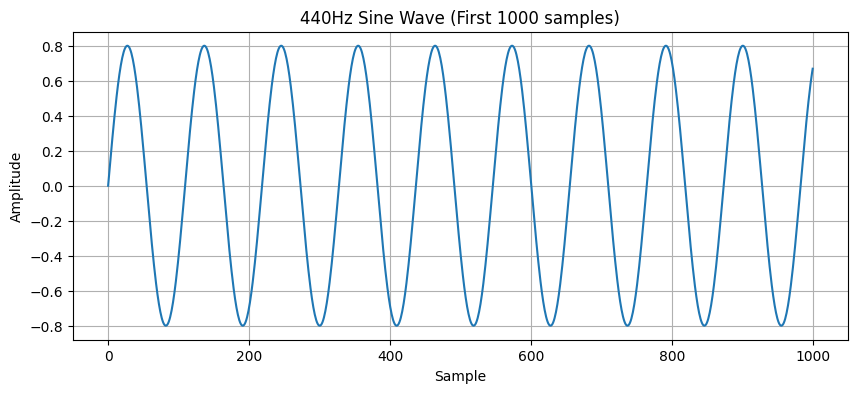

In [2]:
from sfumato.utils.audio_source import AudioSource

# インスタンス化 (48kHz)
source = AudioSource(sample_rate=48000)

# パターンA: 440Hz (A4) の音を 0.1秒作る
tone_data = source.sine_tone(frequency=440.0, duration=0.1)

plt.figure(figsize=(10, 4))
plt.plot(tone_data[:1000])  # 最初の1000サンプルだけ表示
plt.title("440Hz Sine Wave (First 1000 samples)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

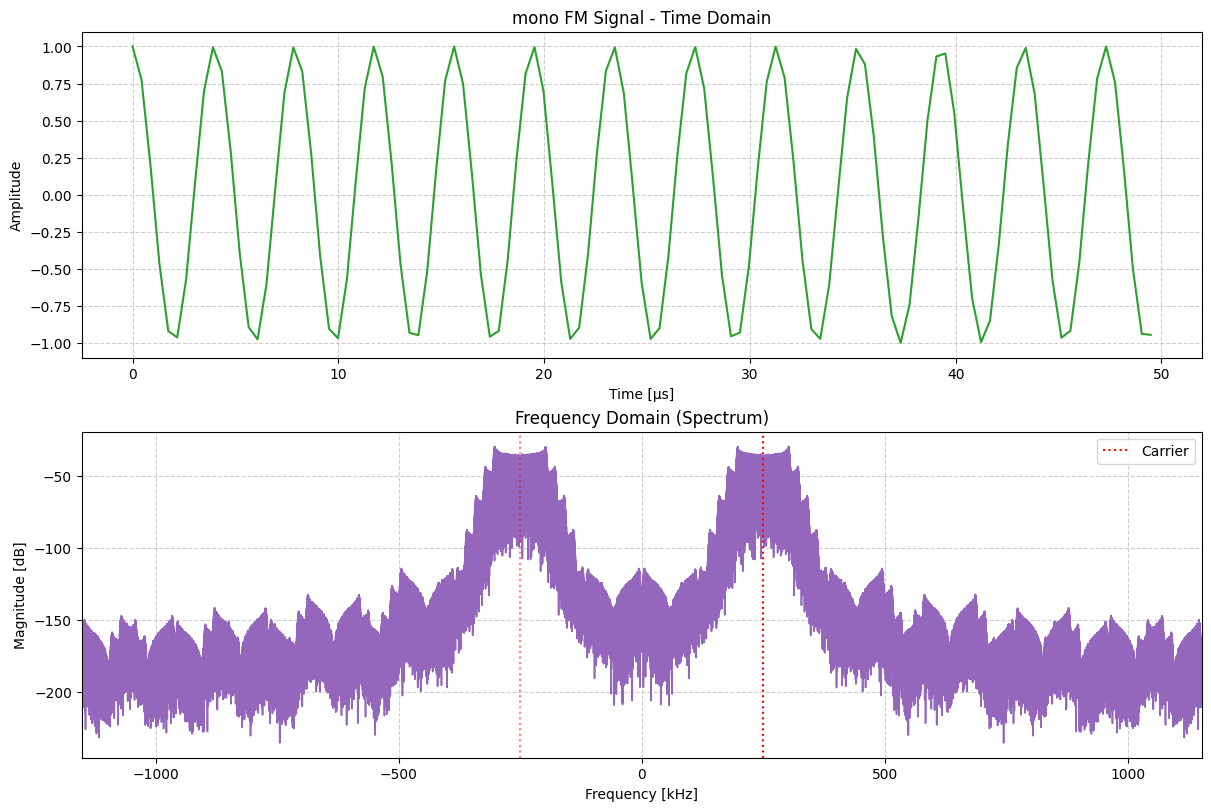

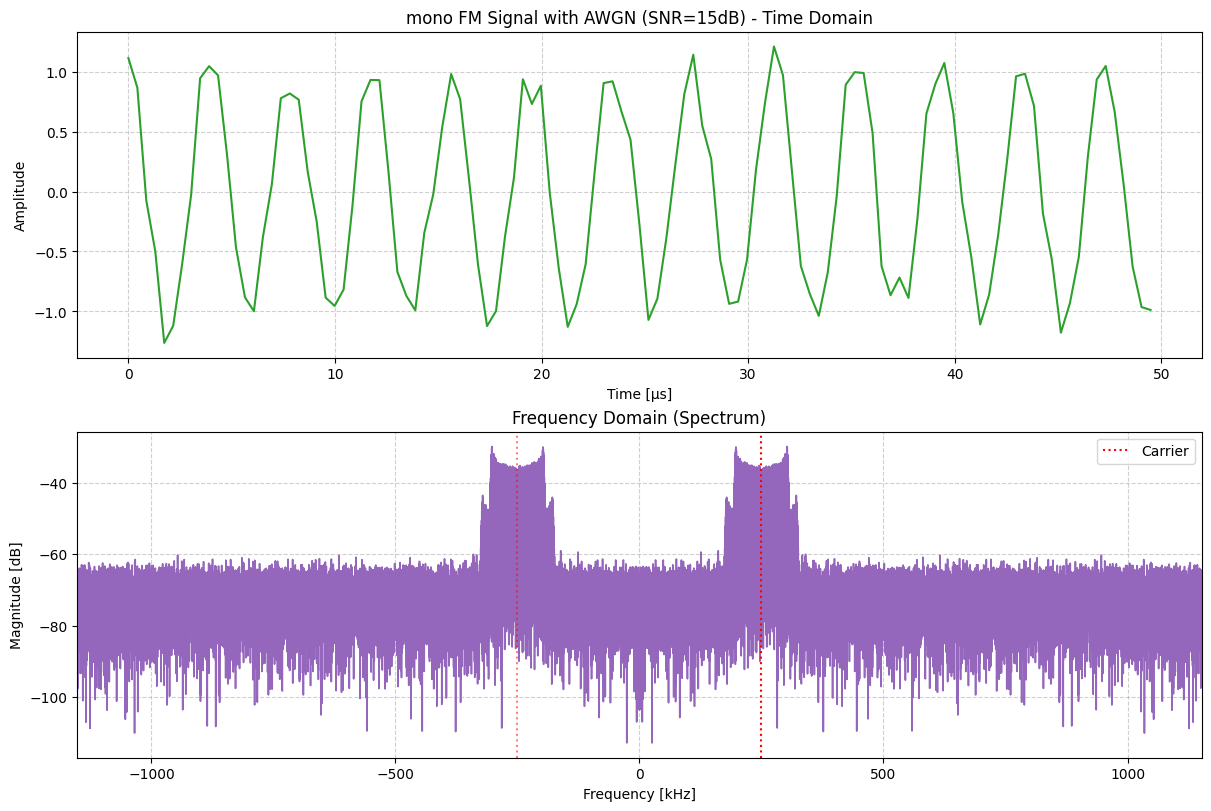

In [3]:
from sfumato import transmitter
from sfumato.channnel import add_awgn

tx = transmitter.FmTransmitter()
mono_signal_clean = tx.modulate(tone_data)
mono_signal_noisy = add_awgn(mono_signal_clean, snr_db=15.0)

plot_signal_analysis(
    mono_signal_clean,
    fs=tx.rf_fs,
    title="mono FM Signal",
    zoom_usec=50,
    carrier_freq=tx.fc,
)

plot_signal_analysis(
    mono_signal_noisy,
    fs=tx.rf_fs,
    title="mono FM Signal with AWGN (SNR=15dB)",
    zoom_usec=50,
    carrier_freq=tx.fc,
)

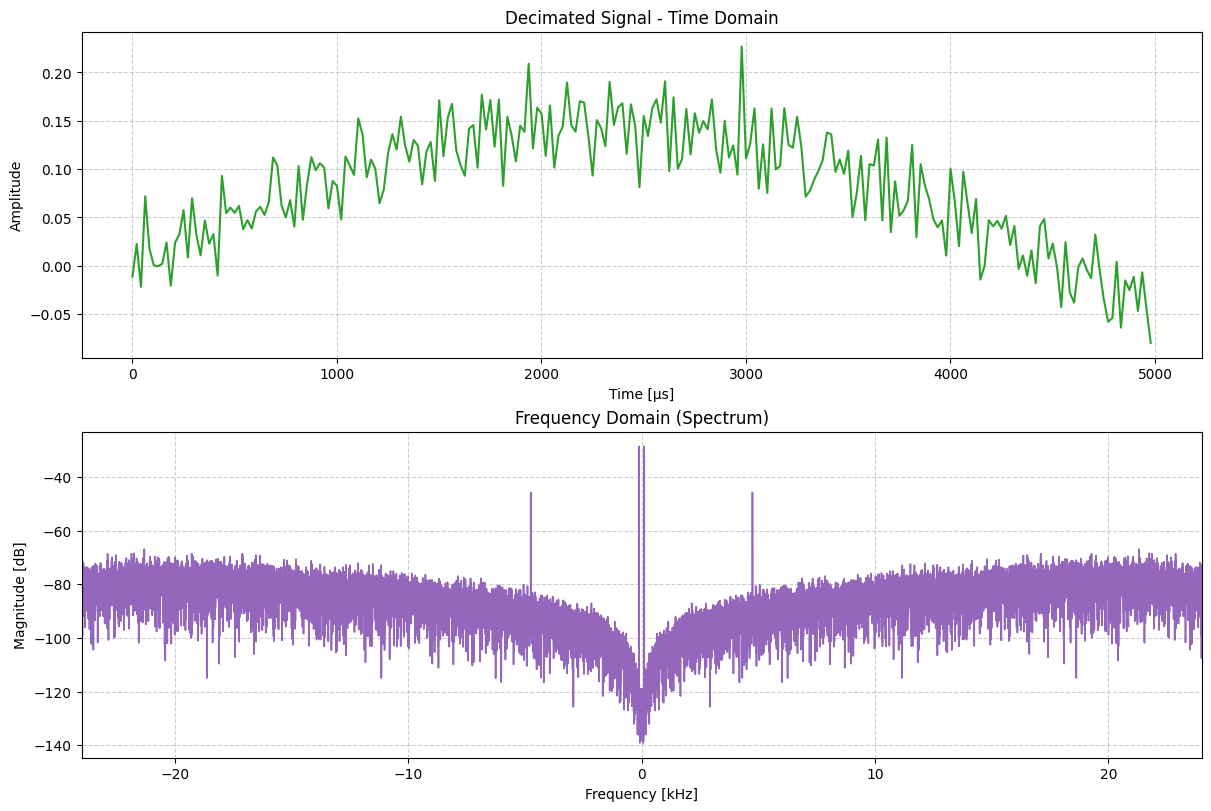

In [4]:
from sfumato import reciever

rx = reciever.FmReceiver()

decimated_iq = rx.process(mono_signal_noisy)
plot_signal_analysis(
    decimated_iq,
    fs=rx.audio_fs,
    title="Decimated Signal",
    zoom_usec=5000,
    xlim_freq=[-24, 24],
)

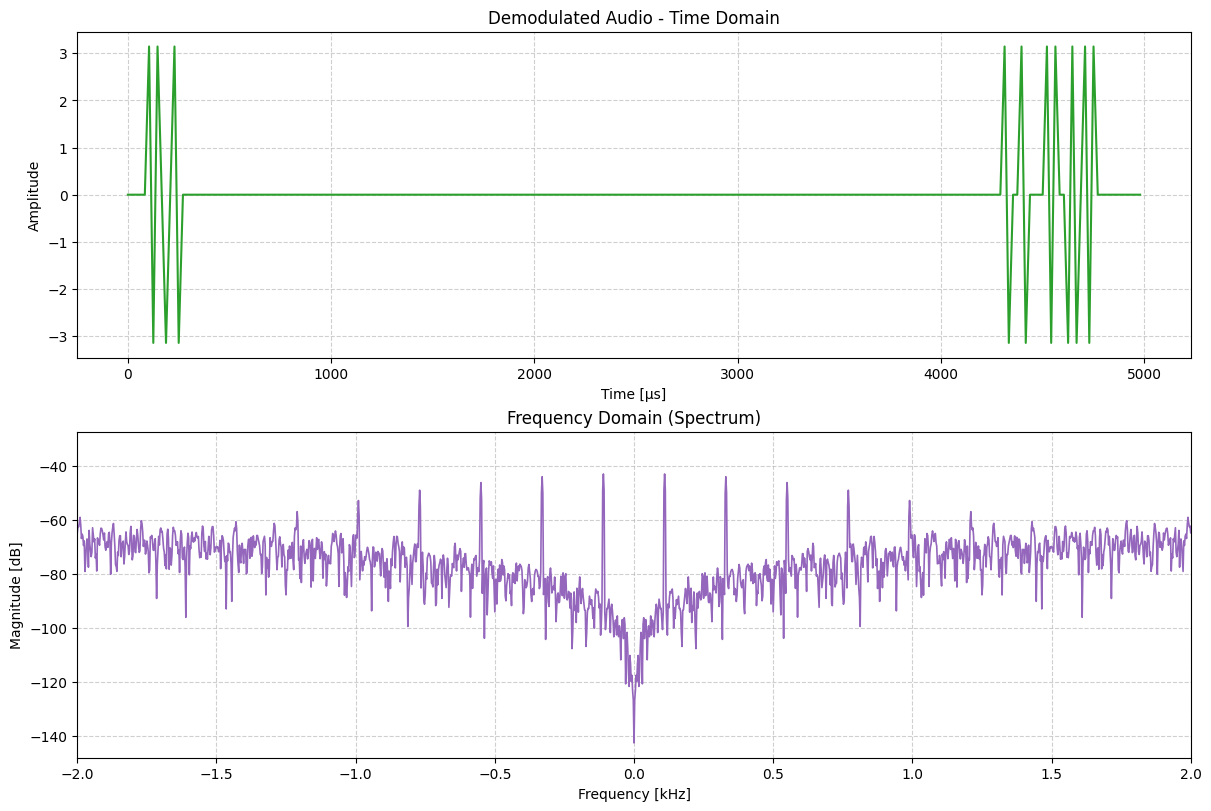

In [14]:
demodulated_audio = rx._demodulate(decimated_iq)
plot_signal_analysis(
    demodulated_audio,
    fs=rx.audio_fs,
    title="Demodulated Audio",
    zoom_usec=5000,
    xlim_freq=[-2, 2],
)

ステレオ

In [4]:
from sfumato import transmitter
from sfumato.channnel import add_awgn
from sfumato import reciever

tx = transmitter.FmTransmitter()
rx = reciever.FmReceiver()

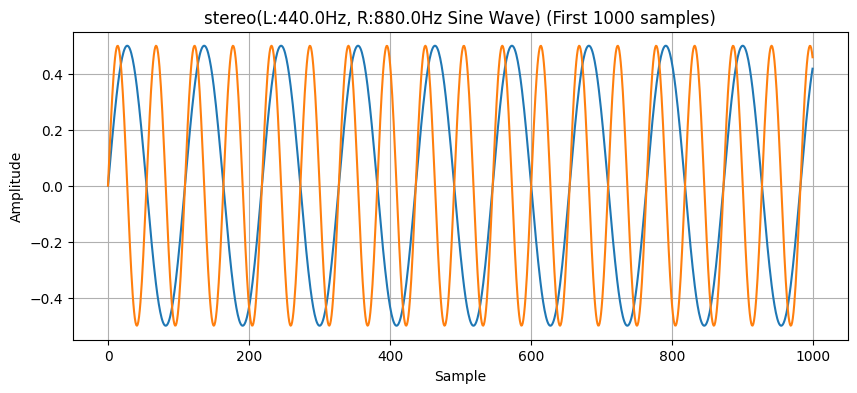

In [5]:
from sfumato.utils.audio_source import AudioSource

# インスタンス化 (48kHz)
source = AudioSource(sample_rate=48000)

freq_l = 440.0
freq_r = 880.0

tone_data = source.stereo_sine_tone(freq_l=freq_l, freq_r=freq_r, duration=0.1)

plt.figure(figsize=(10, 4))
plt.plot(tone_data[:1000])  # 最初の1000サンプルだけ表示
plt.title(f"stereo(L:{freq_l}Hz, R:{freq_r}Hz Sine Wave) (First 1000 samples)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

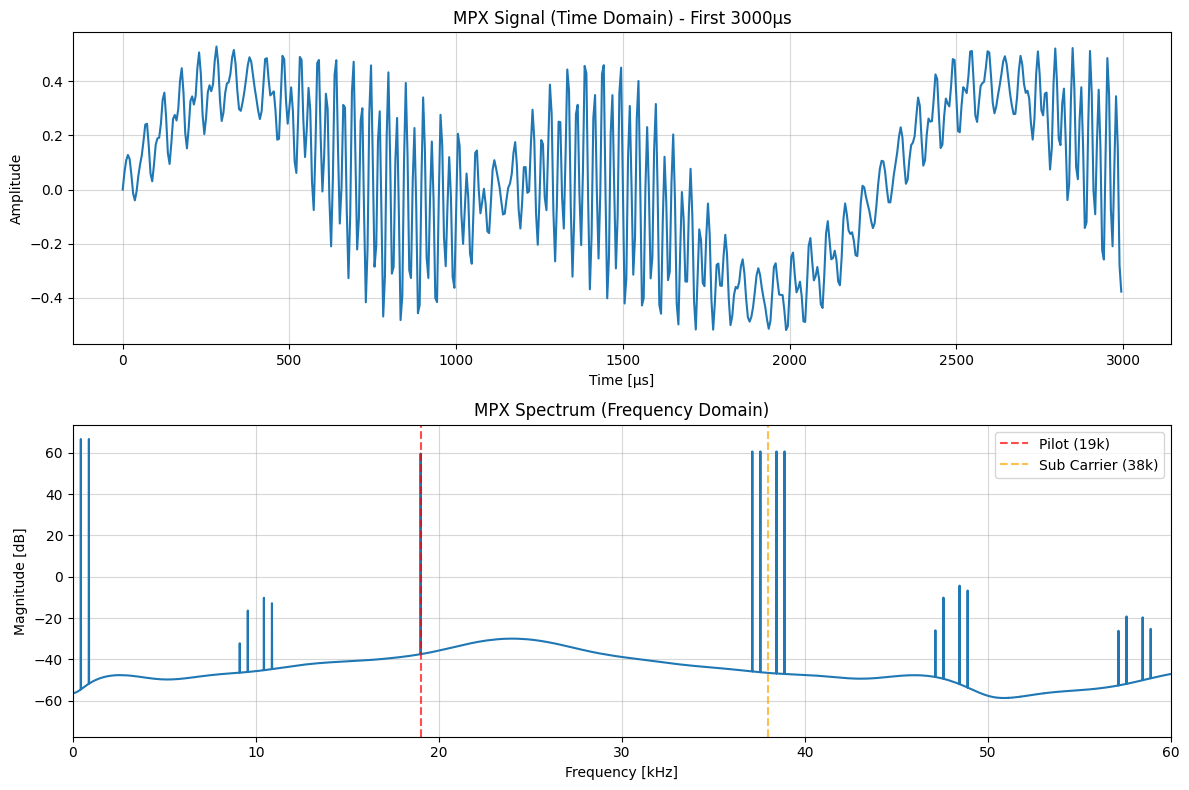

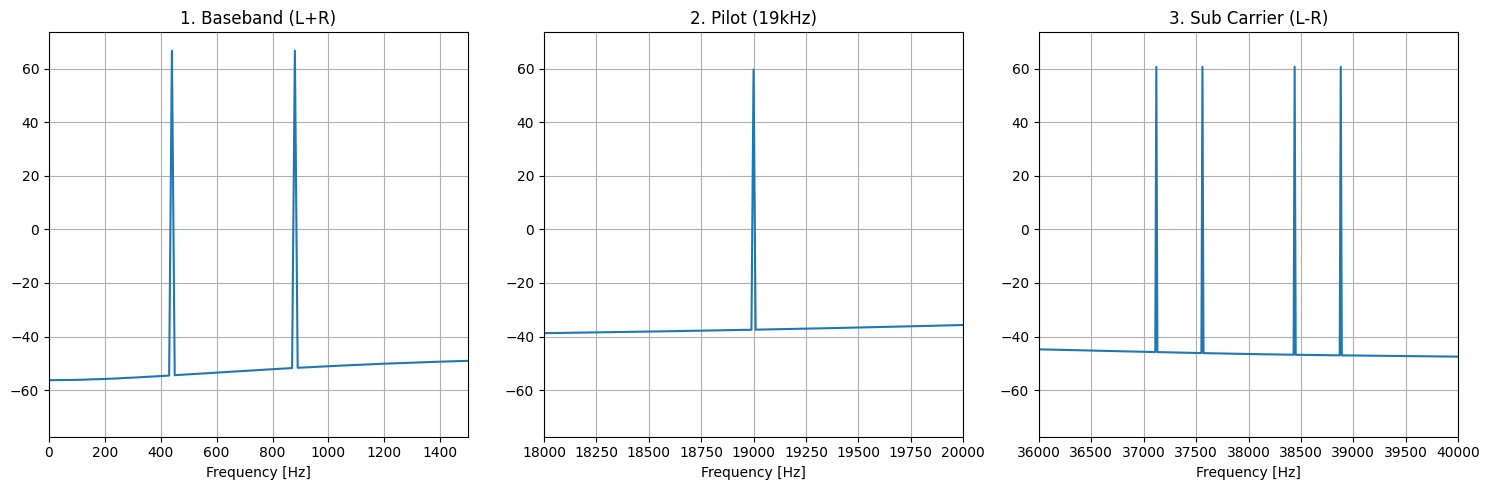

In [6]:
# --- 1. MPX信号の生成 ---
l_ch = tone_data[:, 0]
r_ch = tone_data[:, 1]

# アップサンプリング (Audio 48k -> MPX 192k)
l_upsampled = tx._upsample(l_ch, tx.audio_fs, tx.mpx_fs)
r_upsampled = tx._upsample(r_ch, tx.audio_fs, tx.mpx_fs)

# MPX信号 (コンポジット) の生成
mpx_signal = tx._generate_mpx(l_upsampled, r_upsampled)

# --- 2. 可視化 ---


def analyze_mpx(signal, fs):
    N = len(signal)
    t = np.arange(N) / fs

    # 周波数解析 (FFT)
    freqs = np.fft.rfftfreq(N, d=1 / fs)
    mag = np.abs(np.fft.rfft(signal))
    mag_db = 20 * np.log10(mag + 1e-12)  # ゼロ除算防止

    plt.figure(figsize=(12, 8))

    # --- 上段: 時間波形 ---
    plt.subplot(2, 1, 1)
    # パイロット(19kHz)の周期は約52μs。
    subset_samples = int(fs * 0.003)
    plt.plot(t[:subset_samples] * 1e6, signal[:subset_samples])
    plt.title("MPX Signal (Time Domain) - First 3000µs")
    plt.xlabel("Time [µs]")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.5)

    # --- 下段: 周波数スペクトル ---
    plt.subplot(2, 1, 2)
    plt.plot(freqs / 1000, mag_db)
    plt.title("MPX Spectrum (Frequency Domain)")
    plt.xlabel("Frequency [kHz]")
    plt.ylabel("Magnitude [dB]")
    plt.grid(True, which="both", alpha=0.5)

    # 重要なポイントに赤線を引く
    plt.axvline(19, color="red", linestyle="--", alpha=0.7, label="Pilot (19k)")
    plt.axvline(
        38, color="orange", linestyle="--", alpha=0.7, label="Sub Carrier (38k)"
    )
    plt.xlim(0, 60)  # 60kHzまで見えれば十分
    plt.legend()

    plt.tight_layout()
    plt.show()


analyze_mpx(mpx_signal, fs=tx.mpx_fs)


def analyze_mpx_zoomed(signal, fs):
    N = len(signal)
    freqs = np.fft.rfftfreq(N, d=1 / fs)
    mag = np.abs(np.fft.rfft(signal))
    mag_db = 20 * np.log10(mag + 1e-12)

    plt.figure(figsize=(15, 5))

    # 1. 低域 (Baseband)
    plt.subplot(1, 3, 1)
    plt.plot(freqs, mag_db)
    plt.xlim(0, 1500)  # 0Hz - 1.5kHz
    plt.title("1. Baseband (L+R)")
    plt.xlabel("Frequency [Hz]")
    plt.grid(True)
    # ここに 440Hz, 880Hz があるはず

    # 2. パイロット (Pilot)
    plt.subplot(1, 3, 2)
    plt.plot(freqs, mag_db)
    plt.xlim(18000, 20000)  # 18k - 20k
    plt.title("2. Pilot (19kHz)")
    plt.xlabel("Frequency [Hz]")
    plt.grid(True)

    # 3. サブキャリア (L-R Sidebands)
    plt.subplot(1, 3, 3)
    plt.plot(freqs, mag_db)
    plt.xlim(36000, 40000)  # 36k - 40k
    plt.title("3. Sub Carrier (L-R)")
    plt.xlabel("Frequency [Hz]")
    plt.grid(True)
    # ここに 4本のサイドバンドが見えるはず

    plt.tight_layout()
    plt.show()


# 実行
analyze_mpx_zoomed(mpx_signal, fs=tx.mpx_fs)

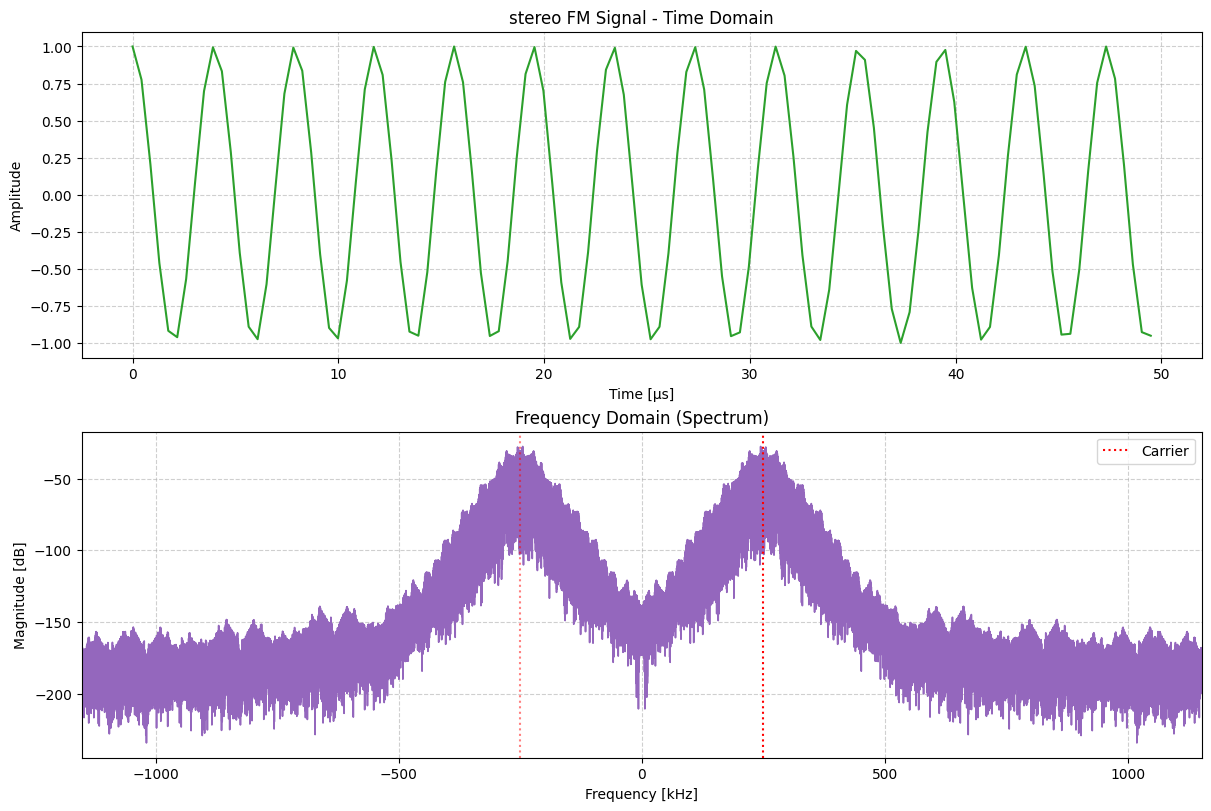

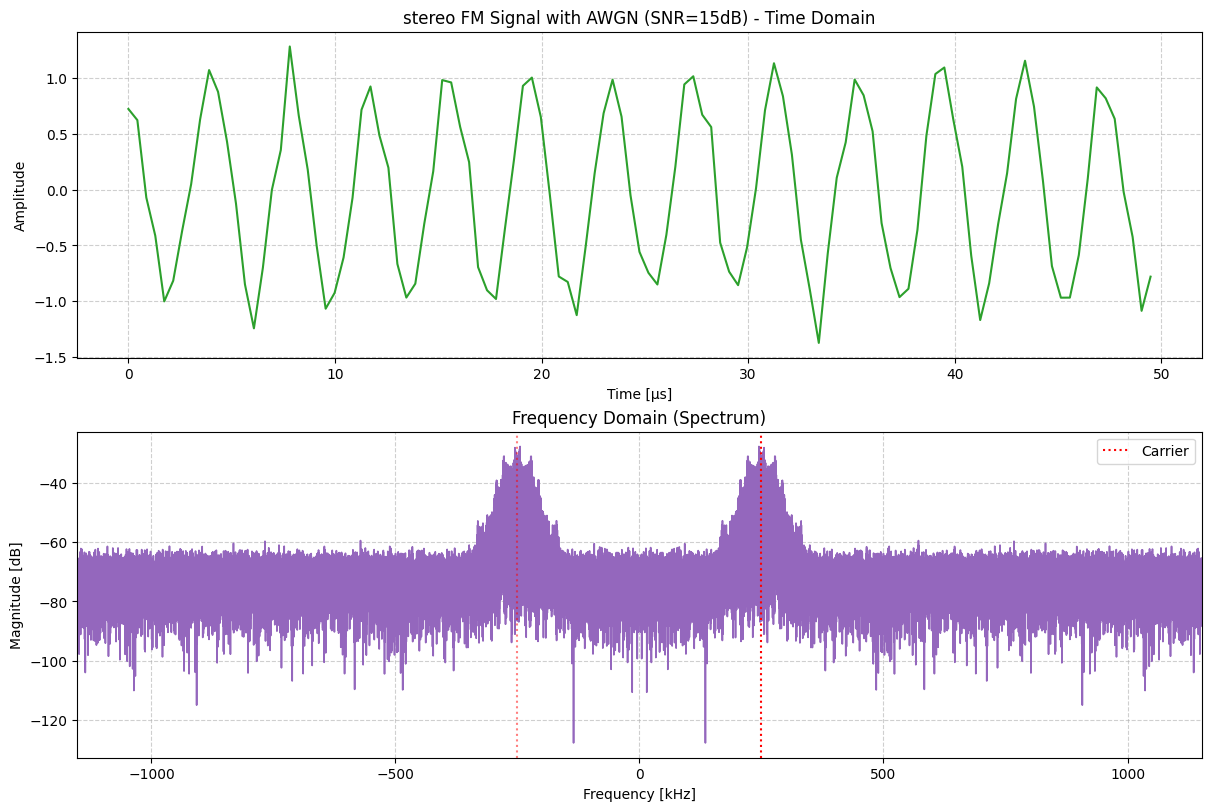

In [7]:
stereo_signal_clean = tx.modulate(tone_data)
stereo_signal_noisy = add_awgn(stereo_signal_clean, snr_db=15.0)

plot_signal_analysis(
    stereo_signal_clean,
    fs=tx.rf_fs,
    title="stereo FM Signal",
    zoom_usec=50,
    carrier_freq=tx.fc,
)

plot_signal_analysis(
    stereo_signal_noisy,
    fs=tx.rf_fs,
    title="stereo FM Signal with AWGN (SNR=15dB)",
    zoom_usec=50,
    carrier_freq=tx.fc,
)

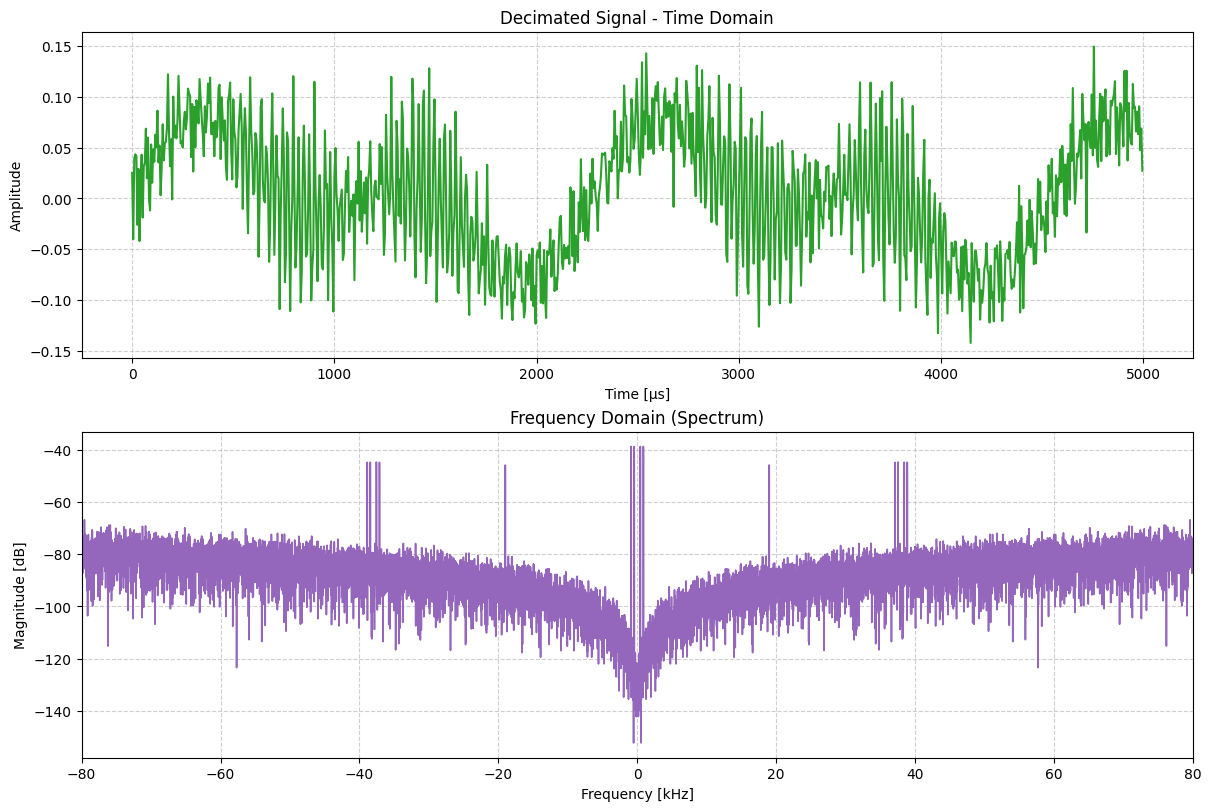

In [8]:
stereo_decimated_iq = rx.process(stereo_signal_noisy)
plot_signal_analysis(
    stereo_decimated_iq,
    fs=rx.mpx_fs,
    title="Decimated Signal",
    zoom_usec=5000,
    xlim_freq=[-80, 80],
)

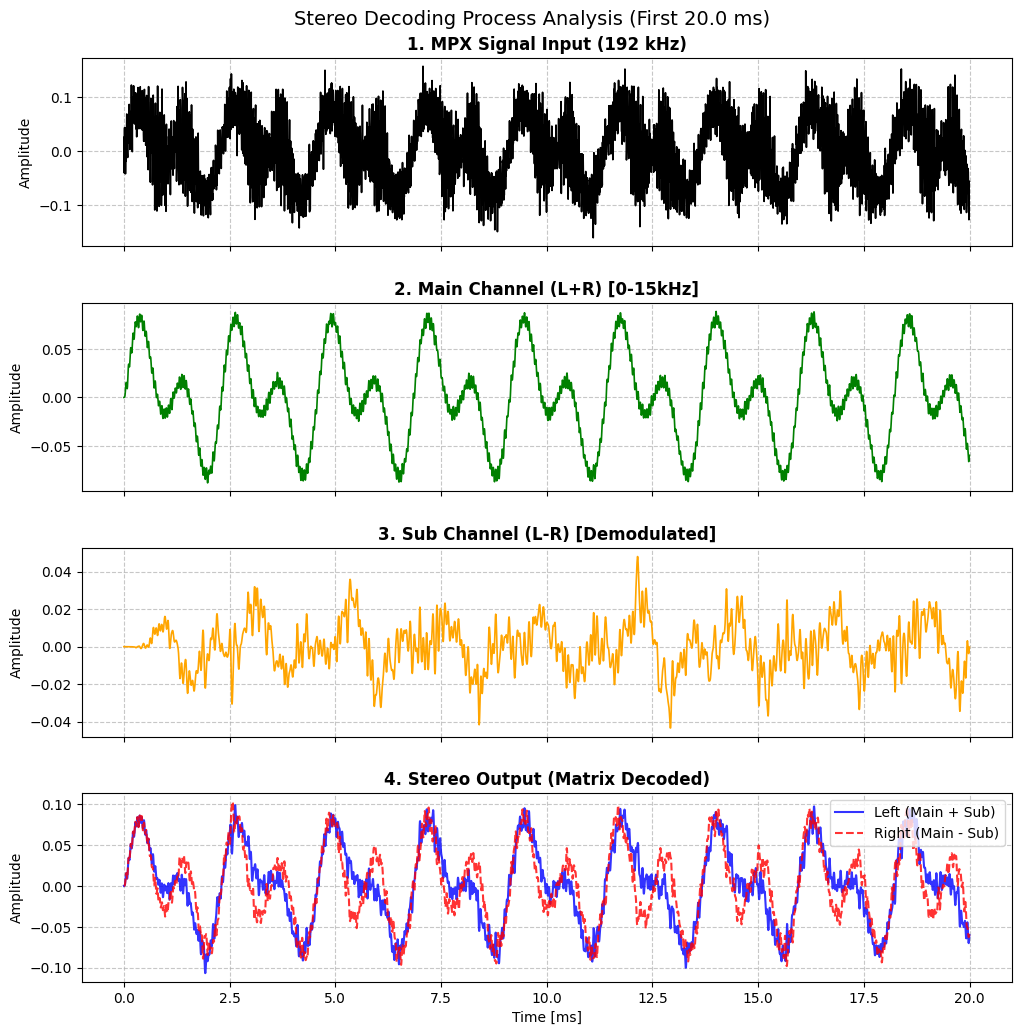

In [9]:
carrier_38k = rx._recover_carrier(stereo_decimated_iq)
stereo_decoded_audio = rx._stereo_decode(stereo_decimated_iq, carrier_38k)

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


def analyze_stereo_decoding(
    receiver,
    mpx_signal: np.ndarray,
    carrier_38k: np.ndarray,
    duration_sec: float = 0.02,
):
    """
    ステレオ復調の内部プロセス（Main, Sub, Matrix分離）を再現し、波形を可視化する。

    Args:
        receiver: FmReceiverインスタンス (パラメータ取得用)
        mpx_signal: MPX信号 (192kHz)
        carrier_38k: 再生された38kHz搬送波
        duration_sec: 描画する期間 (秒)
    """
    fs = receiver.mpx_fs
    nyquist = fs / 2

    # --- 1. 信号処理 (Signal Processing) ---
    # 受信機の内部ロジックをトレースして、中間信号を生成します

    # フィルタ設計 helper
    def butter_filter(order, cutoff, btype="low"):
        if isinstance(cutoff, list):
            Wn = [c / nyquist for c in cutoff]
        else:
            Wn = cutoff / nyquist
        return signal.butter(order, Wn, btype=btype)

    # A. Main (L+R) の抽出
    b_main, a_main = butter_filter(5, 15000, "low")
    main_signal = signal.lfilter(b_main, a_main, mpx_signal)

    # B. Sub (L-R) の抽出と復調
    # BPF (23k-53k) -> 検波 -> LPF (15k)
    b_sub, a_sub = butter_filter(5, [23000, 53000], "band")
    sub_modulated = signal.lfilter(b_sub, a_sub, mpx_signal)

    # 同期検波 (振幅補正 x2.0)
    sub_demodulated_raw = sub_modulated * carrier_38k * 2.0
    sub_signal = signal.lfilter(b_main, a_main, sub_demodulated_raw)

    # C. マトリックス分離
    left_ch = main_signal + sub_signal
    right_ch = main_signal - sub_signal

    # --- 2. 可視化 (Visualization) ---
    # 描画範囲のサンプル数計算
    num_samples = int(fs * duration_sec)
    t = np.arange(num_samples) / fs * 1000  # ms単位に変換

    # プロット設定
    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    plt.subplots_adjust(hspace=0.3)

    # 共通描画関数
    def plot_waveform(ax, data, title, color, ylim=None):
        ax.plot(t, data[:num_samples], color=color, linewidth=1.2)
        ax.set_title(title, fontsize=12, fontweight="bold")
        ax.set_ylabel("Amplitude")
        ax.grid(True, linestyle="--", alpha=0.7)
        if ylim:
            ax.set_ylim(ylim)

    # Plot 1: MPX Signal (Raw Input)
    plot_waveform(axes[0], mpx_signal, "1. MPX Signal Input (192 kHz)", "black")

    # Plot 2: Main Signal (L+R)
    plot_waveform(axes[1], main_signal, "2. Main Channel (L+R) [0-15kHz]", "green")

    # Plot 3: Sub Signal (L-R)
    plot_waveform(axes[2], sub_signal, "3. Sub Channel (L-R) [Demodulated]", "orange")

    # Plot 4: Final Stereo Output
    axes[3].plot(
        t,
        left_ch[:num_samples],
        label="Left (Main + Sub)",
        color="blue",
        alpha=0.8,
        linewidth=1.5,
    )
    axes[3].plot(
        t,
        right_ch[:num_samples],
        label="Right (Main - Sub)",
        color="red",
        alpha=0.8,
        linewidth=1.5,
        linestyle="--",
    )
    axes[3].set_title(
        "4. Stereo Output (Matrix Decoded)", fontsize=12, fontweight="bold"
    )
    axes[3].set_xlabel("Time [ms]")
    axes[3].set_ylabel("Amplitude")
    axes[3].grid(True, linestyle="--", alpha=0.7)
    axes[3].legend(loc="upper right")

    plt.suptitle(
        f"Stereo Decoding Process Analysis (First {duration_sec * 1000:.1f} ms)",
        fontsize=14,
        y=0.92,
    )
    plt.show()


# --- 実行 ---
# 変数名を mpx_signal に統一して渡すのがベターです
mpx_signal = stereo_decimated_iq  # 変数名の読み替え

analyze_stereo_decoding(
    receiver=rx,
    mpx_signal=mpx_signal,
    carrier_38k=carrier_38k,
    duration_sec=0.02,  # 20ms
)